## Data Cleaning Assignment
To complete this challenge, determine the five most common journals and the total articles for each. Next, calculate the mean, median, and standard deviation of the open-access cost per article for each journal.

<a href="https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/WELLCOME/WELLCOME_APCspend2013_forThinkful.csv">CSV file</a> and <a href="https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/WELLCOME/Readme_file.docx">description of the dataset</a>

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

##used encoding = "ISO-8859-1" to overcome unicode decoding error
initial = pd.read_csv('C:\Thinkful\Data Cleaning\WELLCOME_APCspend2013_forThinkful.csv', encoding="ISO-8859-1")
initial.head(2)

,PMID/PMCID,Publisher,Journal title,Article title,COST (£) charged to Wellcome (inc VAT when charged)
0,NaN,CUP,Psychological Medicine,Reduced parahippocampal cortical thickness in ...,£0.00
1,PMC3679557,ACS,Biomacromolecules,Structural characterization of a Model Gram-ne...,£2381.04


In [2]:
##change bad column name
initial.rename({'COST (£) charged to Wellcome (inc VAT when charged)': 'Cost'}, axis='columns', inplace=True)

##begin to clean and standardize journal titles
initial['Journal title'].value_counts().head()
##first step seems to be to consolidate PLoS One entries

PLoS One                                           92
PLoS ONE                                           62
Journal of Biological Chemistry                    48
Nucleic Acids Research                             21
Proceedings of the National Academy of Sciences    19
Name: Journal title, dtype: int64

In [3]:
##used regex to consolidate PLOS ONE
initial['Journal title'] = initial['Journal title'].apply(lambda x: re.sub(r'plos one|plosone|plos 1', 'PLOS ONE', str(x), flags=re.I))
initial['Journal title'].value_counts().head(50)

PLOS ONE                                                   206
Journal of Biological Chemistry                             48
Nucleic Acids Research                                      21
Proceedings of the National Academy of Sciences             19
PLoS Neglected Tropical Diseases                            18
Human Molecular Genetics                                    18
Nature Communications                                       17
PLoS Pathogens                                              15
Neuroimage                                                  15
PLoS Genetics                                               15
NeuroImage                                                  14
BMC Public Health                                           14
Brain                                                       14
Movement Disorders                                          13
Developmental Cell                                          12
Journal of Neuroscience                                

In [4]:
##check for null values
initial['Journal title'].isnull().sum()

0

In [5]:
initial['Cost'].isnull().sum()

0

#### Five most common journals and article counts:

In [6]:
initial['Journal title'].value_counts().head(5)

PLOS ONE                                           206
Journal of Biological Chemistry                     48
Nucleic Acids Research                              21
Proceedings of the National Academy of Sciences     19
PLoS Neglected Tropical Diseases                    18
Name: Journal title, dtype: int64

#### Summary Statistics

In [7]:
initial['Cost'].head()

0       £0.00
1    £2381.04
2     £642.56
3     £669.64
4     £685.88
Name: Cost, dtype: object

Looks like we need to strip the pound sign and convert the column from str to int so we can perform statistical analysis.

In [8]:
##use regex to remove all non numeric chars from cost column
initial['Cost'] = initial['Cost'].apply(lambda x: re.sub('[^\.0-9]', '', x))
##convert column to float
initial['Cost'] = pd.to_numeric(initial['Cost'])
##convert column to int
initial['Cost'] = initial['Cost'].apply(lambda x: int(x))
initial['Cost'].head()

0       0
1    2381
2     642
3     669
4     685
Name: Cost, dtype: int64

Let's plot the costs to explore the data.

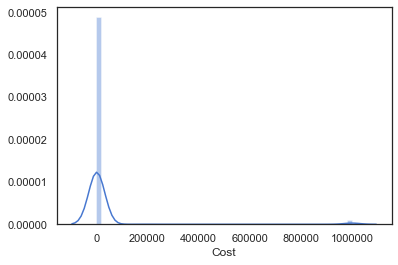

In [9]:
sns.set(color_codes=True)
sns.set(style="white", palette="muted")
sns.distplot(initial.Cost)

It looks like there is a very large outlier, let's try to find the reason.

In [10]:
##count total values in cost column
initial.Cost.count()

2127

In [11]:
##count the number of dirty outlier values
initial.groupby('Cost').count().tail(2)

,PMID/PMCID,Publisher,Journal title,Article title
Cost,,,,
201024,1,1,1,1
999999,40,47,47,47


In [12]:
##see zero values
initial.groupby('Cost').count().head(2)

,PMID/PMCID,Publisher,Journal title,Article title
Cost,,,,
0,0,1,1,1
9,1,1,1,1


So we have 47 out of over 2000 values that seem to be dirty. Simply dropping them would seem the best way to improve the sample. 

In [13]:
##drop rows with 999999 as cost
clean_cost = initial[initial['Cost'] != 999999].sort_values('Cost', ascending=False)
clean_cost.Cost.head()

1987    201024
1470    192645
986      13200
1619      6000
800       5760
Name: Cost, dtype: int64

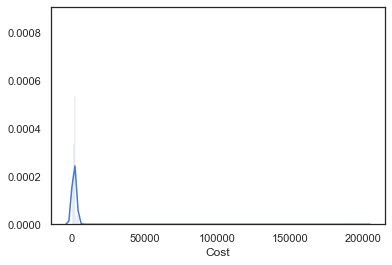

In [14]:
cost_plot = sns.distplot(clean_cost.Cost, bins=1000)
cost_plot

The data still seem very skewed. However, with a lack of knowledge of the academic publishing field, at this point I'm not sure if that means it is dirty or not. Either way, removing the remaining outliers might still be helpful to understand the rest of the data. My instinct tells me there is a missing decimal place resulting a wrongly large number for the remaining two largest cost figures.

In [15]:
clean_cost.head()

,PMID/PMCID,Publisher,Journal title,Article title,Cost
1987,PMC3664409\n\n,Wiley,Movement Disorders,Limb amputations in fixed dystonia: a form of ...,201024
1470,3547931,Public Library of Science,PLOS ONE,Reducing stock-outs of life saving Malaria Com...,192645
986,NaN,MacMillan,nan,Fungal Disease in Britain and the United State...,13200
1619,543219,public.service.co.uk,Public Service Review,Laboratory Science in Tropical Medicine,6000
800,PMID: 23041239 /PMCID: PMC3490334,Elsevier,The Lancet Neurology,Genetic risk factors for ischaemic stroke and ...,5760


In [16]:
##drop the 3 large outliers
clean_cost = clean_cost[clean_cost.Cost < 10000]
##drop zero value
clean_cost = clean_cost[clean_cost.Cost > 0]
clean_cost.head()

,PMID/PMCID,Publisher,Journal title,Article title,Cost
1619,543219,public.service.co.uk,Public Service Review,Laboratory Science in Tropical Medicine,6000
800,PMID: 23041239 /PMCID: PMC3490334,Elsevier,The Lancet Neurology,Genetic risk factors for ischaemic stroke and ...,5760
648,NaN,Elsevier,Lancet,Global trends in antiretroviral resistance in ...,4800
798,PMCID:\n PMC3627205\n,Elsevier,The Lancet,Effects of unconditional and conditional cash ...,4800
552,23541370 PMC3744751,Elsevier,Elsevier,Effects of relative weight gain and linear gro...,4800


In [17]:
clean_cost.tail()

,PMID/PMCID,Publisher,Journal title,Article title,Cost
975,PMC 3536734,Landes Bioscience,Channels,State-independent intracellular access of quat...,159
1677,NaN,Sciedu Press,Journal of Biomedical Graphics and Computing,Functional MRI demonstrates pain perception in...,135
1469,3543450,Public Library of Science,PLOS ONE,How well are Malaria Maps used to design and ...,122
100,NaN,American Society for Nutrition,American Society for Nutrition,The association between breastfeeding and HIV ...,45
243,PMC3716626,BioMed Central Ltd,Veterinary Research,Understanding foot-and-mouth disease virus tra...,9


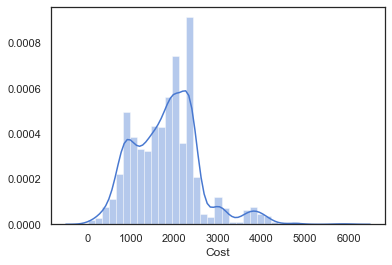

In [18]:
##distribution plot of clean data
clean_plot = sns.distplot(clean_cost.Cost)

In [19]:
##Total cost mean
clean_cost.Cost.mean()

1822.5746628131021

In [20]:
##Total cost median
clean_cost.Cost.median()

1851.5

In [21]:
##total cost standard dev
clean_cost.Cost.std()

766.8697284721012

For all of our cost values, our mean and median are similar at 1822 and 1851, but we have a very large standard deviation of 766. 
Next we'll group by journal.

In [41]:
##group by journal title and find mean cost
grouped = clean_cost.groupby(["Journal title"])['Cost'].mean().reset_index()
grouped.sort_values(by=['Cost'], ascending=False, inplace=True)
grouped.head(20)

,Journal title,Cost
839,Public Service Review,6000.000000
922,The Lancet Neurology,5040.000000
642,Lancet,4800.000000
921,The Lancet,4558.000000
206,Cell Host & Microbe,4226.000000
258,Curr Biol.,4151.000000
208,Cell Journal,4041.000000
434,Immunity,3934.000000
681,Molecular Cell,3925.333333
209,Cell Metabolism,3923.666667


Furthermore, I could better consolidate some of the one-off journal titles, and perform further statistics on each group. But for the sake of this assignment I am going to move onto the next chapter.